In [1]:
cd ../../

/mnt/sda/otani/Experiments/hidden-challenges-MR


In [2]:
from src import settings
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms
from src.toolbox.eval import evaluate, accumulate_metrics
from src.toolbox.data_converters import CharadesSTA2Instances
from src.toolbox.visualization import plot_performance_per_duration
import seaborn as sns
import json
import pickle as pkl
import neptune
sns.set_style("white")

In [3]:
# load ground truth testset
test_data = CharadesSTA2Instances(pd.read_csv('data/processed/charades/charades_test.csv'))

In [4]:
# download result files from neptune project
# you can also download file manually

project = neptune.init("mayu-ot/moment-retrieval")

for exp_id in ["MOM-43", "MOM-51"]:
    if not os.path.exists(f"tmp/{exp_id}/TAN_vgg_rgb_test.pkl"):
        exps = project.get_experiments(id=exp_id)
        print("downloading results ...")
        exps[0].download_artifact("TAN_vgg_rgb_test.pkl", f"tmp/{exp_id}")
        print("done!")

In [5]:
def postproc_prediction(predictions):
    preds = []
    for p in tqdm(predictions, desc="postproc"):
        query = (p[0][0], p[0][1]+".") # 2D-TAN remove '.' in description. Add to recover original input description.
        seg = p[1]
        keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
        seg = [seg[i] for i in keep]
        preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
    return preds

def eval_preds(pred_file):
    print(f"loading prediction file {pred_file}")
    predictions = pkl.load(open(pred_file, "rb"))
    preds = postproc_prediction(predictions)
    results = evaluate(test_data, preds)
    summary = accumulate_metrics(results)
    return results, summary

results, summary = eval_preds("tmp/MOM-43/TAN_vgg_rgb_test.pkl")
randomized_results, randomized_summary = eval_preds("tmp/MOM-51/TAN_vgg_rgb_test.pkl")

loading prediction file tmp/MOM-43/TAN_vgg_rgb_test.pkl


evaluating: 100%|██████████| 3720/3720 [00:00<00:00, 5815.47it/s] 


R@1 IoU>0.3 0.57
R@1 IoU>0.5 0.42
R@1 IoU>0.7 0.22
R@5 IoU>0.3 0.92
R@5 IoU>0.5 0.80
R@5 IoU>0.7 0.51
R@10 IoU>0.3 0.92
R@10 IoU>0.5 0.80
R@10 IoU>0.7 0.51
loading prediction file tmp/MOM-51/TAN_vgg_rgb_test.pkl


evaluating: 100%|██████████| 3720/3720 [00:00<00:00, 5854.79it/s] 

R@1 IoU>0.3 0.54
R@1 IoU>0.5 0.39
R@1 IoU>0.7 0.20
R@5 IoU>0.3 0.91
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.48
R@10 IoU>0.3 0.91
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.48


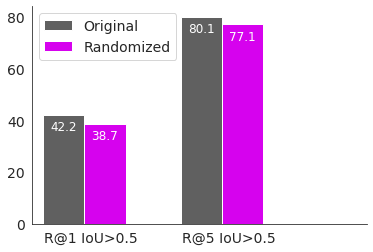

In [9]:
# The performances of the 2D-TAN model when the original and randomized videos are fed to the model
def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-6,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color=color
    )
    
def plot_performance_comparison(sum_a, sum_b, labels):
    plt.figure(figsize=(6, 4))
    c = ["#606060", "#d602ee"]
    keys = [f"R@{k} IoU>0.5" for k in [1, 5]]
    x = np.arange(2)+0.2
    for score_summary, l in zip([sum_a, sum_b], labels):
        vals = [score_summary[k] * 100 for k in keys]
        bars = plt.bar(x, vals, width=0.3, color=c.pop(0), label=l)
        for b in bars:
            display_score(b, color="w")
        x += 0.3

    plt.xticks(ticks=np.arange(3)+0.4, labels=keys, ha="center")
    plt.legend()
    sns.despine(left=False)

plot_performance_comparison(summary, randomized_summary, labels = ["Original", "Randomized"])

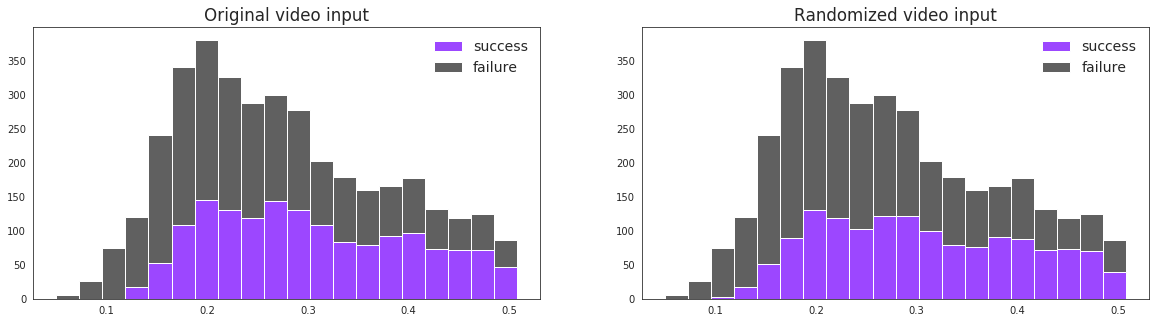

In [7]:
# Check relation between success rates and iput video durations
def plot_comparison_per_duration(results, titles, data):
    f, axes = plt.subplots(1, len(results), figsize=(20, 5))
    plt.rcParams.update({'font.size': 14})
    
    for ax, res, t in zip(axes, results, titles):
        _ = plot_performance_per_duration(res, data, ax=ax)
        ax.set_title(t)


plot_comparison_per_duration(
    (results, randomized_results), 
    ["Original video input", "Randomized video input"],
    test_data)